<a href="https://colab.research.google.com/github/Rishi500/Neural-Networks/blob/master/Multi_label_prediction_with_Planet_Amazon_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle

In [0]:
from google.colab import files

In [0]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rishi500","key":"31bae42537b6b7321ed7f577ebf60bb0"}'}

In [0]:
! mkdir ~/.kaggle

In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
! kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    1GB  2020-04-17 22:02:37          55679  
roche-data-science-coalition/uncover                           UNCOVER COVID-19 Challenge                          123MB  2020-04-08 22:04:30           4884  
praveengovi/coronahack-chest-xraydataset                       CoronaHack -Chest X-Ray-Dataset                       1GB  2020-03-20 01:26:40           1137  
katerpillar/meteonet                                           MeteoNet North-West France                           11GB  2020-04-16 08:35:45             87  
andrewmvd/covid19-ct-scans                    

In [0]:
!kaggle datasets list -s planets_dataset

ref                        title            size  lastUpdated          downloadCount  
-------------------------  ---------------  ----  -------------------  -------------  
nikitarom/planets-dataset  planets_dataset   1GB  2020-02-09 22:01:31            376  


In [0]:
!kaggle datasets download nikitarom/planets-dataset

100% 1.49G/1.50G [00:29<00:00, 51.0MB/s]
100% 1.50G/1.50G [00:29<00:00, 54.2MB/s]


In [0]:
!unzip -q -n /content/train_v2.csv.zip 

unzip:  cannot find or open /content/train_v2.csv.zip, /content/train_v2.csv.zip.zip or /content/train_v2.csv.zip.ZIP.


In [0]:
!ls

kaggle.json  planets-dataset.zip  sample_data


In [0]:
!unzip -q -n /content/planets-dataset.zip

In [0]:
!ls

kaggle.json  planet  planets-dataset.zip  sample_data  test-jpg-additional


In [0]:
from fastai import *
from fastai.vision import *

In [0]:
df = pd.read_csv('/content/planet/planet/train_classes.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv('planet/planet', 'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:

data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

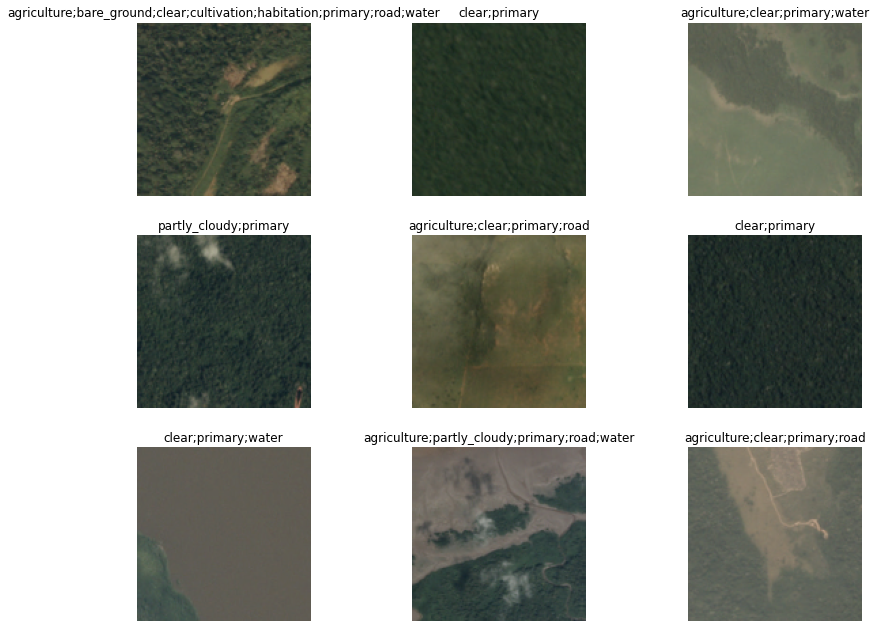

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh = 0.2)
f_score = partial(fbeta , thresh = 0.2)
learn = create_cnn(data, arch, metrics = [acc_02, f_score])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


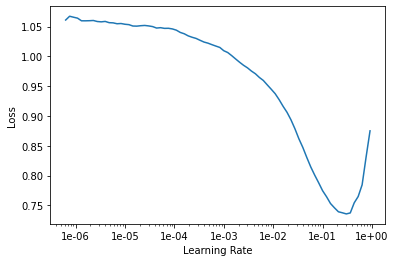

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,slice(1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.138800,0.115866,0.947506,0.899026,03:44
1,0.112094,0.101705,0.952730,0.912821,03:43
2,0.103776,0.093335,0.955027,0.920239,03:42
3,0.097375,0.087477,0.954721,0.924081,03:42
4,0.091576,0.087160,0.955637,0.924396,03:42


In [0]:
learn.save('stage-1-rn50')

In [0]:
learn.unfreeze()

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, (1e-2)/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096920,0.092655,0.955288,0.919571,04:37
1,0.096692,0.088658,0.956153,0.922759,04:35
2,0.094013,0.084925,0.955252,0.928250,04:35
3,0.085326,0.082971,0.957381,0.928551,04:36
4,0.081313,0.082725,0.958275,0.929375,04:36


In [0]:
learn.save('stage-2-rn50')

In [0]:
data1 = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [0]:
learn.data = data1

In [0]:
data1.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


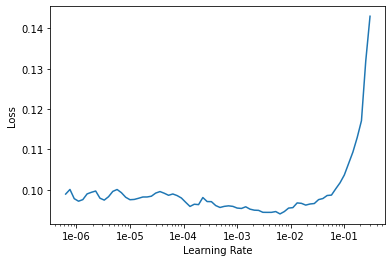

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = (1e-02)/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087966,0.085272,0.955434,0.925684,11:05
1,0.087093,0.085544,0.959496,0.925735,11:01
2,0.085000,0.083202,0.957665,0.928297,11:02
3,0.081316,0.082128,0.960026,0.930253,11:04
4,0.080407,0.081739,0.960607,0.930769,11:04


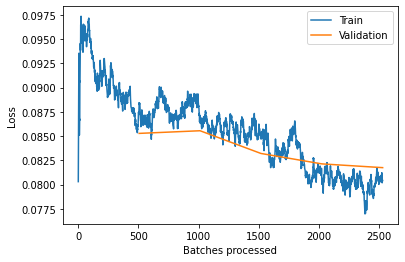

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

In [0]:
learn.save('stage-2-256-rn50')

In [0]:
learn.export()

In [0]:
test = ImageList.from_folder('test-jpg-additional').add(ImageList.from_folder('/test-jpg-additional'))

In [0]:
len(test)

20522

In [0]:
learn = load_learner(path = 'planet/planet', test = test)


In [54]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)


In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv('submission.csv', index=False)